In [1]:
import os
import json
import unicodedata
import re
import prepare as pr
from typing import Dict, List, Optional, Union, cast
import requests
from bs4 import BeautifulSoup
import pandas as pd
import nltk
from nltk.tokenize.toktok import ToktokTokenizer
from nltk.corpus import stopwords
from env import github_token, github_username

# Acquire 

In [2]:
df = pr.get_clean_df()

In [3]:
df

,original,first_clean,clean,lemmatized,language
0,"<p align=""center""><img src=""https://live.stati...",SpaceX REST API Open Source REST API for lau...,spacex rest api open source rest api launch ro...,spacex rest api open source rest api launch ro...,JavaScript
1,\nARCHIVED VERSION OF Space Engineers. This ve...,ARCHIVED VERSION OF Space Engineers. This vers...,archived version engineers version uptodate ve...,archived version engineer version uptodate ver...,C#
2,# Spaceship Generator\n\nA Blender script to p...,# Spaceship Generator A Blender script to pro...,spaceship generator blender script procedurall...,spaceship generator blender script procedurall...,Python
3,# Spacegray\n\nA set of custom UI themes for S...,# Spacegray A set of custom UI themes for Sub...,spacegray set custom ui themes sublime text hy...,spacegray set custom ui theme sublime text hyp...,JavaScript
4,# S P A C E\n\n![cover](resources/space-readme...,# S P A C E ![cover . You can read it here: ...,p c e cover read,p c e cover read,JavaScript
...,...,...,...,...,...
427,# Simple multi-dataset detection\nAn object de...,# Simple multi-dataset detection An object det...,simple multidataset detection object detector ...,simple multidataset detection object detector ...,Python
428,\n![Python package](https://github.com/WagnerG...,![Python package .,python package,python package,Python
429,# UnityScreenSpaceMetaballs\nScreenSpace Metab...,# UnityScreenSpaceMetaballs ScreenSpace Metaba...,unityscreenspacemetaballs screenspace metaball...,unityscreenspacemetaballs screenspace metaball...,C#
430,Caching for Analytic Computations\n-----------...,Caching for Analytic Computations ------------...,caching analytic computations humans repeat st...,caching analytic computation human repeat stuf...,Python


# what percent of our sample is which language? 

In [105]:
def data_representation(df):
    '''this function will create a data frame that shows the count and percentage of the target variable'''
    # creating dataframe of languages and their count and percentages 
    languages_table = pd.concat([df.language.value_counts(),round(df.language.value_counts(normalize=True),2)], axis=1)
    # creating column names for dataframe
    languages_table.columns = ['count', 'percent']
    # displaying table of information 
    return languages_table

In [106]:
# table of the target variables count and perecentage of df 
data_representation(df)

,count,percent
JavaScript,153,0.35
Python,137,0.32
C#,93,0.22
Java,49,0.11


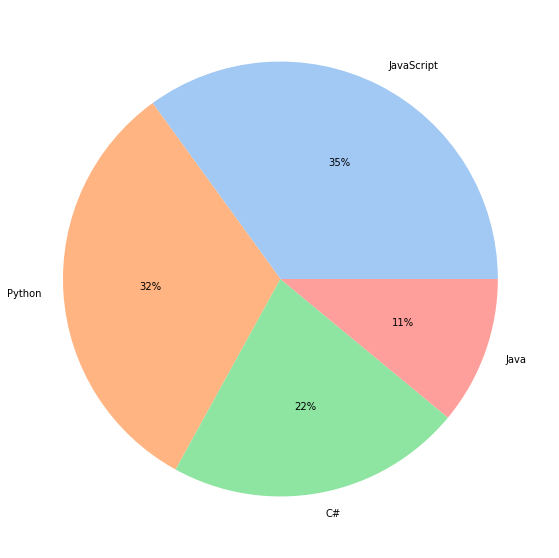

In [110]:
import matplotlib.pyplot as plt
import seaborn as sns
#adjusts size of 
plt.figure(figsize=(20,10))
#define data
data = [35,32,22,11]
labels = ['JavaScript', 'Python', 'C#', 'Java']

#define Seaborn color palette to use
colors = sns.color_palette('pastel')[0:5]

#create pie chart
plt.pie(data, labels = labels, colors = colors, autopct='%.0f%%')
plt.show()

### Takeaways 

- Javascript makes up 35% of the sample 
- Python makes up 31% of sample 
- Based on sample we might infer that these are very popular languges amongst users of github 

In [7]:
from sklearn.model_selection import train_test_split
seed = 42
target = 'language'

def split_3(df):
    '''
    This function takes in a dataframe and splits it into 3 data sets
    Test is 20% of the original dataset, validate is .30*.80= 24% of the 
    original dataset, and train is .70*.80= 56% of the original dataset. 
    The function returns, in this order, train, validate and test dataframes. 
    '''
    #split_db class verision with random seed
    train_validate, test = train_test_split(df, test_size=0.2, 
                                            random_state=seed, stratify=df[target])
    train, validate = train_test_split(train_validate, test_size=0.3, 
                                       random_state=seed, stratify=train_validate[target])
    return train, validate, test

def split_data(df, explore=True):
    '''
    the function accepts a dataframe as a parameter
    splits according to the purpose
    for the exploration returns train, validate, test
    for modeling it drops unneeded columns, creates dummis, and returns
    6 values X_train, y_train ...
    '''

    if explore:
        return split_3(df)
    else:
        train, validate, test = split_3(df)
        return train.iloc[:, :-1], validate.iloc[:, :-1], test.iloc[:, :-1], \
            train[target], validate[target], test[target]

train, _, _ = split_data(df)

In [8]:
train.shape

(241, 5)

In [14]:
def word_groups(df, target):
    # split languages into seperate DataFrames
    js_lang = train[train[target] == 'JavaScript']
    cs_lang = train[train[target] == 'C#']
    jv_lang = train[train[target] == 'Java']
    py_lang = train[train[target] == 'Python']
    
    # create word groups on lemmatized column 
    js_lem = (' '.join(js_lang[js_lang[target] == 'JavaScript']['lemmatized'])).split()
    cs_lem = (' '.join(cs_lang[cs_lang[target] == 'C#']['lemmatized'])).split()
    jv_lem = (' '.join(jv_lang[jv_lang[target] == 'Java']['lemmatized'])).split()
    py_lem = (' '.join(py_lang[py_lang[target] == 'Python']['lemmatized'])).split()
    all_lem = (' '.join(train['lemmatized'])).split()
    
    # create word groups on clean column
    js_clean = (' '.join(js_lang[js_lang[target] == 'JavaScript']['clean'])).split()
    cs_clean = (' '.join(cs_lang[cs_lang[target] == 'C#']['clean'])).split()
    jv_clean = (' '.join(jv_lang[jv_lang[target] == 'Java']['clean'])).split()
    py_clean = (' '.join(py_lang[py_lang[target] == 'Python']['clean'])).split()
    all_clean = (' '.join(train['clean'])).split()
    
    return js_lang, cs_lang, jv_lang, py_lang,all_lem, js_lem, cs_lem, jv_lem, py_lem, js_clean, cs_clean, jv_clean, py_clean, all_clean

In [15]:
js_lang, cs_lang, jv_lang, py_lang,all_lem, js_lem, cs_lem, jv_lem, py_lem, js_clean, cs_clean, jv_clean, py_clean, all_clean = word_groups(train,'language')

In [17]:
# What words occur the most in c sharpe cleaned readme files? 
cs_freq_clean = pd.Series(cs_clean).value_counts()
cs_freq_clean.head()

&#9;     528
v         81
fix       78
fixed     72
parts     71
dtype: int64

In [18]:
js_freq_clean = pd.Series(js_clean).value_counts()
js_freq_clean.head()

fixed       82
x           50
use         41
software    40
v           33
dtype: int64

In [19]:
jv_freq_clean = pd.Series(jv_clean).value_counts()
jv_freq_clean.head()

license    17
use        16
planets    14
support    11
system     11
dtype: int64

In [20]:
py_freq_clean = pd.Series(py_clean).value_counts()
py_freq_clean.head()

python       84
&#9;         56
codeblock    51
subnet       45
image        45
dtype: int64

In [31]:
all_freq_clean = pd.Series(all_clean).value_counts()
all_freq_clean.head()

&#9;        591
fixed       157
use         122
v           117
software     96
dtype: int64

In [32]:
# dataframe of word counts 
word_counts = (pd.concat([cs_freq_clean,js_freq_clean, jv_freq_clean, py_freq_clean,all_freq_clean], axis=1, sort=True)
                .set_axis(['c_sharp','javascript', 'java', 'python','all'], axis=1, inplace=False)
                .fillna(0)
                .apply(lambda s: s.astype(int)))

word_counts.head()


,c_sharp,javascript,java,python,all
&#9;,528,7,0,56,591
aabb,0,2,0,0,2
aaro,1,0,0,0,1
ab,2,1,0,0,3
ability,5,5,0,0,10


In [48]:
# filtering most words by c sharp
word_counts.sort_values(by='javascript', ascending=False).head(10)

,c_sharp,javascript,java,python,all
fixed,72,82,1,2,157
x,3,50,0,4,57
use,38,41,16,27,122
software,37,40,3,16,96
v,81,33,2,1,117
new,11,31,3,12,57
create,2,29,0,24,55
system,8,28,11,3,50
bug,10,25,0,0,35
without,21,25,7,14,67


In [33]:
# filtering most words by c sharp
word_counts.sort_values(by='c_sharp', ascending=False).head(10)

,c_sharp,javascript,java,python,all
&#9;,528,7,0,56,591
v,81,33,2,1,117
fix,78,1,0,2,81
fixed,72,82,1,2,157
parts,71,3,0,1,75
drag,50,1,0,0,51
ksp,48,0,0,0,48
part,46,5,0,2,53
stiffening,44,0,0,0,44
features,44,8,7,17,76


## Takeaways 
- Unique words for C sharp appear to be ksp/stiffening (doesn't appear in other languages), 
- drag less used by other languages as well
- Most used is &#9

In [53]:
# filtering most words by python
word_counts.sort_values(by='python', ascending=False).head(5)


,c_sharp,javascript,java,python,all
python,0,1,1,84,86
&#9;,528,7,0,56,591
codeblock,0,0,0,51,51
subnet,0,0,0,45,45
image,0,3,0,45,48


## Takeaways 
- python used infrequently in other readme files 
- codeblock and subnet not used by other languages 
- most used word is python 

In [78]:
(word_counts
 [(word_counts.javascript > 70) & (word_counts.java < 10) & (word_counts.c_sharp > 0)]
 .assign(ratio=lambda df: df.javascript / (df.java + .01))
 .sort_values(by='ratio')
 .pipe(lambda df: pd.concat([df.head(), df.tail()])))


,c_sharp,javascript,java,python,all,ratio
fixed,72,82,1,2,157,81.188119
fixed,72,82,1,2,157,81.188119


## Bigrams 


In [111]:
# top 20 bi grams for c sharp lemmitized 
top_20_csharp_lem_bigrams = (pd.Series(nltk.ngrams(cs_lem, 2)).value_counts().head(10))
top_20_csharp_lem_bigrams

(&#9;, &#9;, &#9;, &#9;)               74
(v, &#9;, feature, &#9;)               26
(decoupler, stiffening, look, part)     8
(part, type, add, stiffening)           8
(beyond, part, type, add)               8
(part, beyond, part, type)              8
(stiffening, look, part, beyond)        8
(&#9;, decoupler, stiffening, look)     8
(look, part, beyond, part)              8
(v, &#9;, bugfixes, &#9;)               7
dtype: int64

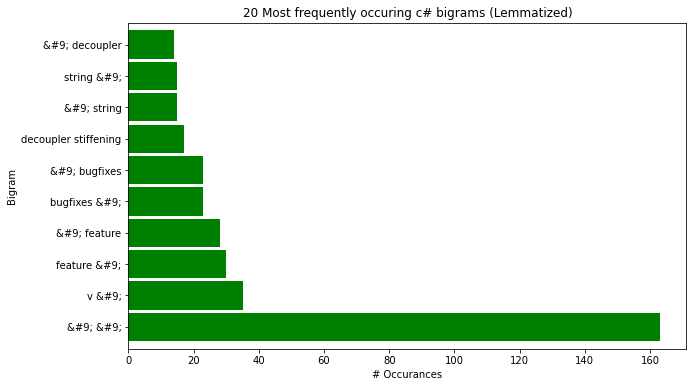

In [94]:
top_20_csharp_lem_bigrams.sort_values(ascending=False).plot.barh(color='green', width=.9, figsize=(10, 6))

plt.title('20 Most frequently occuring c# bigrams (Lemmatized)')
plt.ylabel('Bigram')
plt.xlabel('# Occurances')

# make the labels pretty
ticks, _ = plt.yticks()
labels = top_20_csharp_lem_bigrams.reset_index()['index'].apply(lambda t: t[0] + ' ' + t[1])
_ = plt.yticks(ticks, labels)


In [85]:
top_20_csharp_clean_bigrams = (pd.Series(nltk.ngrams(cs_clean, 2)).value_counts().head(10))
top_20_csharp_clean_bigrams

(&#9;, &#9;)               163
(v, &#9;)                   35
(features, &#9;)            29
(&#9;, features)            28
(&#9;, bugfixes)            23
(bugfixes, &#9;)            23
(decoupler, stiffening)     17
(&#9;, string)              15
(string, &#9;)              15
(&#9;, decoupler)           14
dtype: int64

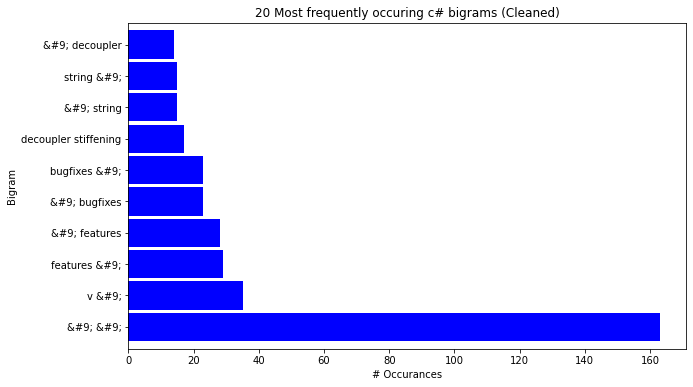

In [96]:
top_20_csharp_clean_bigrams.sort_values(ascending=False).plot.barh(color='blue', width=.9, figsize=(10, 6))

plt.title('20 Most frequently occuring c# bigrams (Cleaned)')
plt.ylabel('Bigram')
plt.xlabel('# Occurances')

# make the labels pretty
ticks, _ = plt.yticks()
labels = top_20_csharp_clean_bigrams.reset_index()['index'].apply(lambda t: t[0] + ' ' + t[1])
_ = plt.yticks(ticks, labels)


In [ ]:
# appears to be small difference between lemmatize and clean bigrams 
- clean bigram appears to have less counts of a few bi grams also shown in lemmatized bi grams 

In [87]:
# top 20 bi grams for c sharp lemmitized 
top_20_python_lem_bigrams = (pd.Series(nltk.ngrams(py_lem, 2)).value_counts().head(10))
top_20_python_lem_bigrams

(ip, address)          21
(image, target)        19
(codeblock, text)      16
(codeblock, python)    13
(pip, install)         12
(target, alt)          11
(codeblock, shell)     10
(please, refer)        10
(codeblock, bash)       9
(feature, network)      8
dtype: int64

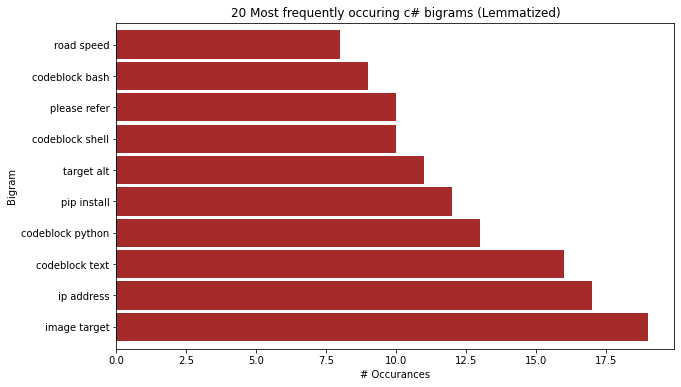

In [99]:
top_20_python_lem_bigrams.sort_values(ascending=False).plot.barh(color='brown', width=.9, figsize=(10, 6))

plt.title('20 Most frequently occuring c# bigrams (Lemmatized)')
plt.ylabel('Bigram')
plt.xlabel('# Occurances')

# make the labels pretty
ticks, _ = plt.yticks()
labels = top_20_python_lem_bigrams.reset_index()['index'].apply(lambda t: t[0] + ' ' + t[1])
_ = plt.yticks(ticks, labels)


In [102]:
# top 20 bi grams for c sharp lemmitized 
top_20_python_clean_bigrams = (pd.Series(nltk.ngrams(py_clean, 2)).value_counts().head(10))
top_20_python_clean_bigrams

(image, target)        19
(ip, address)          17
(codeblock, text)      16
(codeblock, python)    13
(pip, install)         12
(target, alt)          11
(codeblock, shell)     10
(please, refer)        10
(codeblock, bash)       9
(road, speed)           8
dtype: int64

(image, target)        19
(ip, address)          17
(codeblock, text)      16
(codeblock, python)    13
(pip, install)         12
(target, alt)          11
(codeblock, shell)     10
(please, refer)        10
(codeblock, bash)       9
(road, speed)           8
dtype: int64


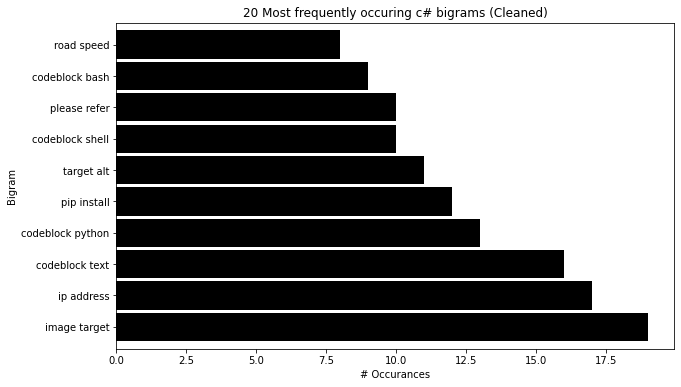

In [104]:
top_20_python_clean_bigrams.sort_values(ascending=False).plot.barh(color='black', width=.9, figsize=(10, 6))

plt.title('20 Most frequently occuring c# bigrams (Cleaned)')
plt.ylabel('Bigram')
plt.xlabel('# Occurances')
print(top_20_python_clean_bigrams)
# make the labels pretty
ticks, _ = plt.yticks()
labels = top_20_python_clean_bigrams.reset_index()['index'].apply(lambda t: t[0] + ' ' + t[1])
_ = plt.yticks(ticks, labels)

In [ ]:
# slight difference between the cleaned and lemmatized version of python bi grams 

## Statistical questions 

In [ ]:
Is the length of characters in the lemmatized python string significantly different than the other languages? 

In [113]:
# zach code for string lengths
# python string lengths


    js_lang = train[train[target] == 'JavaScript']
    cs_lang = train[train[target] == 'C#']
    jv_lang = train[train[target] == 'Java']
    py_lang = train[train[target] == 'Python']
    
    
js_lang['lem str len'] = df['lemmatized'].str.len()
Python = df[df.language == 'Python']
JavaScript = df[df.language == 'JavaScript']
C = df[df.language == 'C#']
Java = df[df.language == 'Java']
print('python = ' , Python.lem_length.mean(), 'Javascript = ', JavaScript.lem_length.mean(), 'C# =', C.lem_length.mean(), 'Java =', Java.lem_length.mean())

AttributeError: 'DataFrame' object has no attribute 'lem_length'